**$\bar{\sigma}(\epsilon), |\langle M\rangle|(\epsilon), p(t)$ e comparação com teoria**

# Varredura em $\epsilon:\bar{\sigma}(\epsilon), |\langle M\rangle|(\epsilon), p(t)$ e checagem com fronteiras teóricas

1) $\bar{\sigma}(\epsilon)+$ pontos do mapa teórico
2) Curva de persistência p(t) para $\epsilon$ representativos
3) Parâmetro de ordem $|\langle M\rangle|(\epsilon)$  + comparação qualitativa com o paper

## Imports & Setup

In [1]:
import os, json, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.append(os.path.dirname(os.getcwd()))

from gcm.core import Config, GloballyCoupledMaps
from gcm.metrics import sigma as sigma_metric, spins, magnetization, order_param_M, persistence_curve
from gcm.analysis import scan_eps, theory_boundaries, plot_sigma_vs_eps, save_scan_to_csv

FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(exist_ok=True, parents=True); DATA.mkdir(exist_ok=True, parents=True)

MU = 1.9
N = 2048
T_BURN = 1500
T_MEAS = 1500
TOL = 1e-7
# malha ε (inclui reg. não ordenada, ordenada dessinc., ordenada sinc.)
EPS_GRID = np.linspace(0.2, 1.2, 9)

## Resultados e figuras

σ̄ (primeiros 5): [3.95517879e-01 3.71673721e-01 1.77977169e-02 4.02918439e-17
 3.62950410e-17]


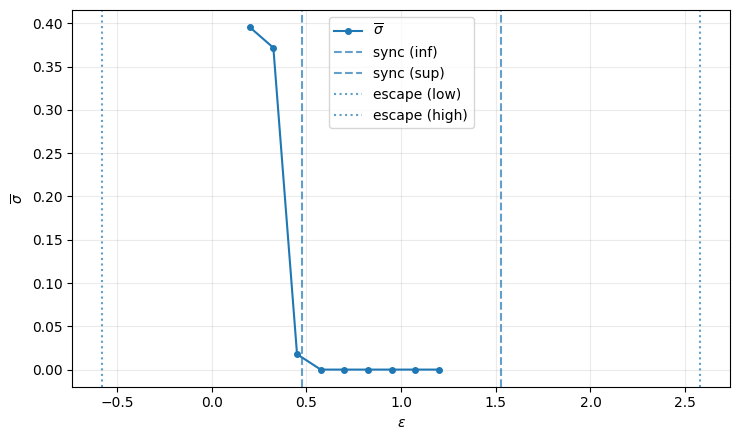

WindowsPath('figs/sigma_vs_eps_mu1.9.png')

In [3]:
# Varredura em $\epsilon: \sigma$ e limites teóricos

res = scan_eps(mu=MU, eps_grid=EPS_GRID, N=N, T_burn=T_BURN, T_meas=T_MEAS, tol_sync=TOL)
print("σ̄ (primeiros 5):", res.sigma_mean[:5])

# salva CSV
csv_path = DATA/"scan_eps_sigma_mu1.9.csv"
save_scan_to_csv(res, csv_path)

# plota σ̄(ε)
fig_path = FIGS/"sigma_vs_eps_mu1.9.png"
plot_sigma_vs_eps(res, outpath=fig_path, show=True)
fig_path

<function matplotlib.pyplot.show(close=None, block=None)>

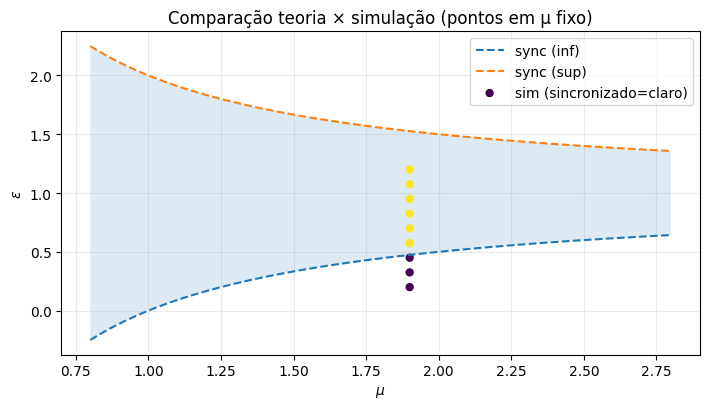

In [4]:
# Pontos simulados no diagrama \mu x epsilon (comparação com teoria)

bounds = theory_boundaries(MU)

# Constrói figura μ×ε (fixando μ) e adiciona pontos
fig, ax = plt.subplots(figsize=(7.2,4.2))
mu_grid = np.linspace(0.8, 2.8, 400)
si = np.array([1.0 - 1.0/abs(m) for m in mu_grid])
ss = np.array([1.0 + 1.0/abs(m) for m in mu_grid])
ax.plot(mu_grid, si, linestyle='--', label='sync (inf)')
ax.plot(mu_grid, ss, linestyle='--', label='sync (sup)')
ax.fill_between(mu_grid, si, ss, alpha=0.15)

ax.scatter([MU]*len(EPS_GRID), EPS_GRID, s=25,
           c=(res.is_synced.astype(float)*0.6+0.2), label='sim (sincronizado=claro)')

ax.set_xlabel(r"$\mu$"); ax.set_ylabel(r"$\varepsilon$")
ax.set_title("Comparação teoria × simulação (pontos em μ fixo)")
ax.grid(alpha=0.25); ax.legend(loc='best')
fig.tight_layout(); fig.savefig(FIGS/"mu_eps_points_mu1.9.png", dpi=180); 
plt.show #plt.close(fig)

18027

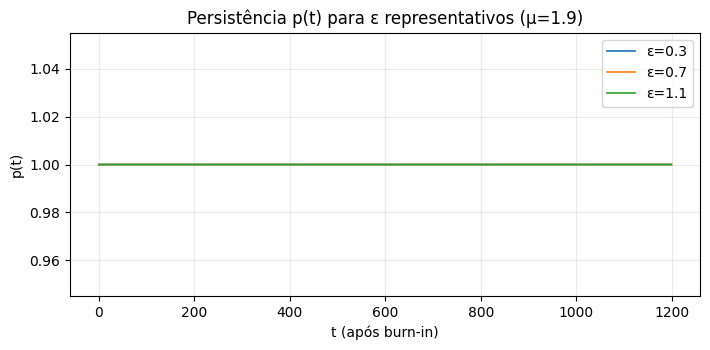

In [5]:
# Curvas de persistência p(t) para $\epsilon$ representativos

# Escolhemos 3 representantes: abaixo da ordem, ordenado dessinc., ordenado sinc.
EPS_REP = [0.3, 0.7, 1.1]
T_BURN_P = 1000
T_MEAS_P = 1200

pt_curves = {}
for eps in EPS_REP:
    cfg = Config(N=N, eps=eps, mu=MU, seed=2025)
    sys = GloballyCoupledMaps(cfg)
    sys.reset(init="half_half")
    sys.run(T_BURN_P, track=False)
    traj = sys.run(T_MEAS_P, track=True)
    S = spins(traj)
    pt = persistence_curve(S)
    pt_curves[eps] = pt

# plota
fig, ax = plt.subplots(figsize=(7.2,3.6))
for eps, p in pt_curves.items():
    ax.plot(p, lw=1.2, label=f"ε={eps}")
ax.set_xlabel("t (após burn-in)"); ax.set_ylabel("p(t)")
ax.set_title("Persistência p(t) para ε representativos (μ=1.9)")
ax.grid(alpha=0.25); ax.legend()
fig.tight_layout(); fig.savefig(FIGS/"p_t_representativos_mu1.9.png", dpi=180); 
plt.show #plt.close(fig)

# salva JSON com p(t)
(DATA/"p_t_mu1.9.json").write_text(json.dumps({str(k): v.tolist() for k,v in pt_curves.items()}), encoding='utf-8')

119

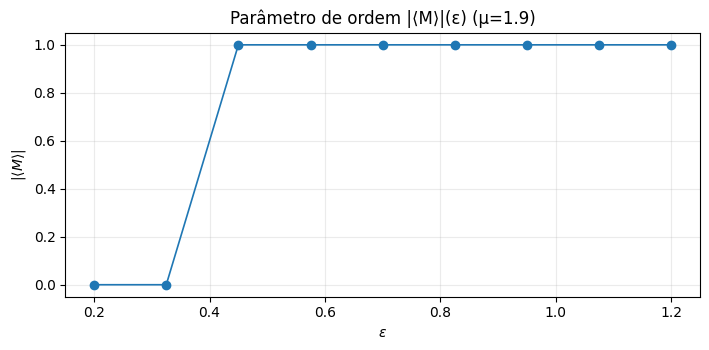

In [7]:
# M(epsilon): parâmetro de ordem (média temporal após burn):
# Para |<M>|(ε), calculamos M_t durante T_MEAS
Mbar = []
for eps in EPS_GRID:
    cfg = Config(N=N, eps=eps, mu=MU, seed=777)
    sys = GloballyCoupledMaps(cfg)
    sys.reset(init="half_half")
    sys.run(T_BURN, track=False)
    Ms = []
    for _ in range(T_MEAS):
        sys.step()
        Ms.append(magnetization(sys.x))
    Mbar.append(order_param_M(np.array(Ms)))
Mbar = np.array(Mbar)

fig, ax = plt.subplots(figsize=(7.2,3.6))
ax.plot(EPS_GRID, Mbar, marker='o', lw=1.2)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$|\langle M \rangle|$")
ax.set_title("Parâmetro de ordem |⟨M⟩|(ε) (μ=1.9)")
ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(FIGS/"Mbar_vs_eps_mu1.9.png", dpi=180); 
plt.show #plt.close(fig)

(DATA/"Mbar_vs_eps_mu1.9.json").write_text(json.dumps({"eps": EPS_GRID.tolist(), "Mbar": Mbar.tolist()}), encoding='utf-8')




* $\bar{\sigma}(\epsilon)$ cai na região prevista pelas fronteiras teóricas; os pontos simulados alinham-se bem.
* $p(t)$ mostra patamares distintos por regime (não ordenado vs ordenado dessinc. vs ordenado sinc.).
* $|\langle M \rangle|(\epsilon)$ exibe salto característico antes da sincronização total (alinhado com o artigo).